# 数据预处理

In [1]:
#绘图库
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#数据预处理
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
#模型训练
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score,recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report
#分类器
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

数据集中的数据包括9种攻击类型，分别是Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode和Worms。在csv文件最后的一列是标签，0代表郑，1代表攻击
加载训练数据UNSW_NB15_training.csv，检查前5行

In [2]:
#加载数据
initial_data = pd.read_csv('UNSW_NB15 dataset/UNSW_NB15_training-set.csv')
initial_data.head(n=5)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
#弃用缺失值
data_to_use = initial_data.dropna()
data_to_use.shape

(175341, 45)

然后看看数据是否平衡，一方面是看9种攻击类型是否平滑（y1指代这方面的标签），一方面是看正常和恶意的数据量是否平衡（y2指代这方面的标签）

In [4]:
X = data_to_use.drop(axis=1,columns=['attack_cat'])
X = X.drop(axis=1, columns=['label'])

y1 = data_to_use['attack_cat'].values
y2 = data_to_use['label'].values

In [5]:
def data_ratio(y2):
    unique, count = np.unique(y2,return_counts=True)
    ratio = round(count[0]/count[1],1)
    return f'{ratio}:1({count[0]}/{count[1]})'

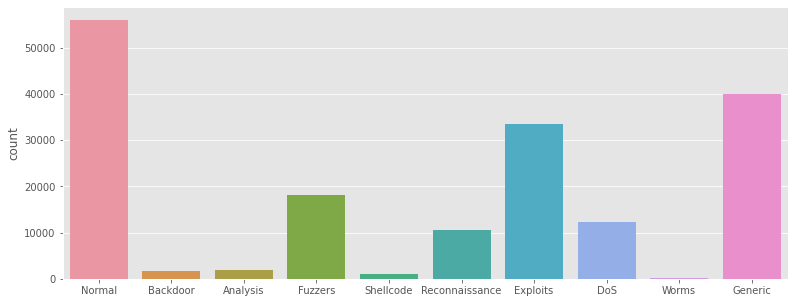

In [6]:
plt.figure(figsize=(13,5))
sns.countplot(y1,label='Sum')
plt.show()

The class ratio for the original data: 0.5:1(56000/119341)


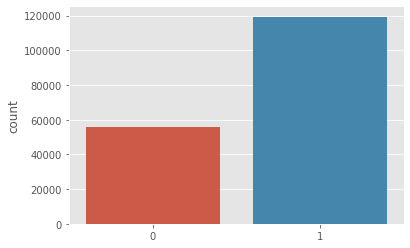

In [7]:
print ('The class ratio for the original data:',data_ratio(y2))
sns.countplot(y2,label='sum')
plt.show()

In [8]:
#加载数据
test_data = pd.read_csv('UNSW_NB15 dataset/UNSW_NB15_testing-set.csv')
X_test = test_data.drop(axis=1,columns=['attack_cat'])
X_test = X_test.drop(axis=1,columns=['label'])

y1_test = test_data['attack_cat'].values
y2_test = test_data['label'].values
X_train = X
y1_train = y1
y2_train = y2
# X_train, X_test, y1_train, y1_test = train_test_split(X,y1,test_size=0.3,random_state=1)

In [9]:
X_test.shape

(82332, 43)

In [10]:
X_train.shape

(175341, 43)

# 数据转换

转换数据:
需要确定哪些列是分类数据（categorical）,哪些列是数值数据(numerical)（分类数据也叫qualitative data或是Yes/No data，是定性的，而数值数据是定量的）

In [11]:
numerical_cols = X_train.select_dtypes(include=['int64','float64']).columns
categorical_cols = X_train.select_dtypes(include=['object','bool']).columns

In [12]:
numerical_cols

Index(['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl',
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports'],
      dtype='object')

In [13]:
categorical_cols

Index(['proto', 'service', 'state'], dtype='object')

对于分类数据应用OneHotEncoder，将其编码为独热数值数组;
对于数值数据应用StandardScaler，通过去除均值和缩放到单位方差来标准化;
构造ColumnTransformer对象，在X_train上进行fit即可。

In [14]:
t = [('ohe',OneHotEncoder(handle_unknown='ignore'),categorical_cols),
     ('scale',StandardScaler(),numerical_cols)]
col_trans = ColumnTransformer(transformers=t)
col_trans.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('ohe',
                                 OneHotEncoder(categorical_features=None,
                                               categories=None, drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               n_values=None, sparse=True),
                                 Index(['proto', 'service', 'state'], dtype='object')),
                                ('scale',
                                 StandardScaler(copy=True, with_...
       'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit',
       'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat',
       'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'c

每个transformer分别转换x，将结果拼接起来

In [15]:
X_train_transform = col_trans.transform(X_train)

In [16]:
X_train_transform.shape

(175341, 195)

对测试集也进行同样的处理

In [17]:
X_test_transform = col_trans.transform(X_test)

In [18]:
X_test_transform.shape

(82332, 195)

In [19]:
pd.unique(y1)

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [20]:
target_trans = LabelEncoder()
target_trans.fit(y1_train)

LabelEncoder()

In [21]:
y1_train_transform = target_trans.transform(y1_train)
y1_test_transform = target_trans.transform(y1_test)

# 训练模型-交叉验证

我们训练模型后，会使用5折交叉验证（cross validation,CV）进行验证，
评估模型的指标包括准确率、准确率、召回率、F1 分数、ROC 的 AUC 值；然后使用测试集评估模型看看效果如何
我们以逻辑回归分类器为例

In [ ]:
#逻辑回归分类器
clf = LogisticRegression(solver='lbfgs',random_state=123,max_iter=4000,multi_class="ovr")
#5折交叉验证
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=123)
#评估标准
scoring = ['accuracy','precision_micro','recall_micro','f1_micro']
#执行交叉验证
cv_results = cross_validate(estimator=clf,
                            X=X_train_transform, 
                            y=y1_train_transform,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False)

In [ ]:
cv_results

In [ ]:
cv_results['test_accuracy'].mean()

# 模型测试

In [ ]:
clf.fit(X=X_train_transform,y=y1_train_transform)

#使用测试集进行测试
y_pred_class = clf.predict(X=X_test_transform)
y_pred_score = clf.predict_proba(X=X_test_transform)[:,1]


In [ ]:
#混淆矩阵
cm_ontest = confusion_matrix(y_true=y1_test_transform,y_pred=y_pred_class)
#precision 
precision_ontest = precision_score(y_true=y1_test_transform,y_pred=y_pred_class,average='micro')
#recall
recall_ontest = recall_score(y_true=y1_test_transform,y_pred=y_pred_class,average='micro')
#分类报告
cls_report_ontest = classification_report(y_true=y1_test_transform,y_pred=y_pred_class)

#打印结果
print('The precision score on test-set:{:1.5f}'.format(precision_ontest))
print('The recall score on test-set:{:1.5f}'.format(recall_ontest))
print('Confusion Matrix:\n',cm_ontest)

#打印分类报告
print('Classification Report:\n',cls_report_ontest)


precision是精确率，也称作查全率，等于tp/(tp+fp);这是针对我们预测结果而言的，它表示的是预测为正的样本中有多少是真正的正样本
recall是查准率，也称召回率，等于tp/(tp+fn)；这是针对我们原来的样本而言的，它表示的是样本中的正例有多少被预测正确了
从计算公式可以看出，其实就是分母不同，一个分母是预测为正的样本数，另一个是原来样本中所有的正样本数
如果看单个指标都过于片面，可以通过f1分数来评估模型性能，f1是recall和precision的加权平均，在上面可以看到在0.64左右

# 其他机器学习方法

In [ ]:
models = [('LogisticRegression',LogisticRegression(random_state=123,max_iter=5000,multi_class="ovr")),
         ('DecisionTree',DecisionTreeClassifier(random_state=123)),
         ('RandomForest',RandomForestClassifier(random_state=123)),
         ]
model_name_list=[]
cv_fit_time_mean_list=[]
cv_precision_mean_list=[]
cv_recall_mean_list=[]
cv_f1_mean_list=[]

In [ ]:
for model_name,clf in models:
    model_name_list.append(model_name)
    clf.fit(X=X_train_transform,y=y1_train_transform)
    #交叉验证
    cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=123)
    #评估标准
    scoring = ['accuracy','precision_micro','recall_micro','f1_micro']
    #执行交叉验证
    cv_results = cross_validate(estimator=clf,
                            X=X_train_transform, 
                            y=y1_train_transform,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False)
    cv_fit_time_mean_list.append(cv_results['fit_time'].mean())
    #使用测试集进行测试
    y_pred_class = clf.predict(X=X_test_transform)
    y_pred_score = clf.predict_proba(X=X_test_transform)[:,1]
    #precision 
    precision_ontest = precision_score(y_true=y1_test_transform,y_pred=y_pred_class,average='micro')
    #recall
    recall_ontest = recall_score(y_true=y1_test_transform,y_pred=y_pred_class,average='micro')
    #分类报告
    cls_report_ontest = classification_report(y_true=y1_test_transform,y_pred=y_pred_class)
    

# MLP

In [22]:
clf = MLPClassifier(random_state=123,solver='adam',max_iter=5000)
#5折交叉验证
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=123)
#评估标准
scoring = ['accuracy','precision_micro','recall_micro','f1_micro']
#执行交叉验证
cv_results = cross_validate(estimator=clf,
                            X=X_train_transform, 
                            y=y1_train_transform,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False)

In [23]:
cv_results

{'fit_time': array([503.05598903, 429.45429587, 633.95440817, 511.35405111,
        375.66861892]),
 'score_time': array([0.385921  , 0.37734389, 0.38667083, 0.39791059, 0.38234329]),
 'test_accuracy': array([0.83989621, 0.84932562, 0.84356554, 0.84210226, 0.84491658]),
 'test_precision_micro': array([0.83989621, 0.84932562, 0.84356554, 0.84210226, 0.84491658]),
 'test_recall_micro': array([0.83989621, 0.84932562, 0.84356554, 0.84210226, 0.84491658]),
 'test_f1_micro': array([0.83989621, 0.84932562, 0.84356554, 0.84210226, 0.84491658])}

In [24]:
cv_results['test_accuracy'].mean()

0.8439612425699943